In [17]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

In [7]:
train_path = './RetinalOCT_Dataset/train/'
test_path = './RetinalOCT_Dataset/test/'
val_path = './RetinalOCT_Dataset/val/'
classes = ['AMD','CNV','CSR','DME','DR','DRUSEN','MH','NORMAL']

In [8]:
def load_dataset(base_path):
    images = []
    labels = []
    for label, class_name in enumerate(classes):
        folder_path = os.path.join(base_path, class_name)
        for img in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            img = cv2.resize(img, (256, 256))
            
            #Contrast enhancement
            lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            cl = clahe.apply(l)
            limg = cv2.merge((cl, a, b))
            img = cv2.cvtColor(limg, cv2.COLOR_Lab2RGB)

            img = img.astype(np.float32) / 255.0

            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

In [9]:
train_images, train_labels = load_dataset(train_path)
val_images, val_labels = load_dataset(val_path)
test_images, test_labels = load_dataset(test_path)

In [11]:
np.savez("train.npz", images=train_images, labels=train_labels)
np.savez("val.npz", images=val_images, labels=val_labels)
np.savez("test.npz", images=test_images, labels=test_labels)

In [12]:
train_data = np.load('train.npz')
train_images = train_data['images']
train_labels = train_data['labels']

test_data = np.load('test.npz')
test_images = test_data['images']
test_labels = test_data['labels']

val_data = np.load('val.npz')
val_images = val_data['images']
val_labels = val_data['labels']

In [13]:
num_classes = 8

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(256,256,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

d:\Python\DL\environments\deep_learning\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,587,656 (112.87 MB)

 Trainable params: 29,587,208 (112.87 MB)

 Non-trainable params: 448 (1.75 KB)

In [15]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7
)

checkpoint = ModelCheckpoint(
    'best_cnn_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

callbacks = [early_stop, reduce_lr, checkpoint]

In [16]:
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/100
575/575 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4102 - loss: 1.9596

575/575 ━━━━━━━━━━━━━━━━━━━━ 868s 1s/step - accuracy: 0.4541 - loss: 1.3445 - val_accuracy: 0.4589 - val_loss: 2.1098 - learning_rate: 1.0000e-04
Epoch 2/100
575/575 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5649 - loss: 0.9642

575/575 ━━━━━━━━━━━━━━━━━━━━ 853s 1s/step - accuracy: 0.5828 - loss: 0.9321 - val_accuracy: 0.7171 - val_loss: 0.7234 - learning_rate: 1.0000e-04
Epoch 3/100
575/575 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6602 - loss: 0.7802

575/575 ━━━━━━━━━━━━━━━━━━━━ 755s 1s/step - accuracy: 0.6712 - loss: 0.7614 - val_accuracy: 0.7864 - val_loss: 0.5771 - learning_rate: 1.0000e-04
Epoch 4/100
575/575 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7387 - loss: 0.6271

575/575 ━━━━━━━━━━━━━━━━━━━━ 739s 1s/step - accuracy: 0.7453 - loss: 0.6145 - val_accuracy: 0.7882 - val_loss: 0.5463 - learning_rate: 1.0000e-04
Epoch 5/100
575/575 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7947 - loss: 0.5001

575/575 ━━━━━━━━━━━━━━━━━━━━ 738s 1s/step - accuracy: 0.7936 - loss: 0.4959 - val_accuracy: 0.8271 - val_loss: 0.4593 - learning_rate: 1.0000e-04
Epoch 6/100
575/575 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8337 - loss: 0.3962

575/575 ━━━━━━━━━━━━━━━━━━━━ 730s 1s/step - accuracy: 0.8364 - loss: 0.3893 - val_accuracy: 0.8496 - val_loss: 0.3990 - learning_rate: 1.0000e-04
Epoch 7/100
575/575 ━━━━━━━━━━━━━━━━━━━━ 691s 1s/step - accuracy: 0.8693 - loss: 0.3137 - val_accuracy: 0.8371 - val_loss: 0.4231 - learning_rate: 1.0000e-04
Epoch 8/100
575/575 ━━━━━━━━━━━━━━━━━━━━ 690s 1s/step - accuracy: 0.8998 - loss: 0.2496 - val_accuracy: 0.8429 - val_loss: 0.4404 - learning_rate: 1.0000e-04
Epoch 9/100
575/575 ━━━━━━━━━━━━━━━━━━━━ 688s 1s/step - accuracy: 0.9218 - loss: 0.1937 - val_accuracy: 0.8539 - val_loss: 0.4121 - learning_rate: 5.0000e-05
Epoch 10/100
575/575 ━━━━━━━━━━━━━━━━━━━━ 695s 1s/step - accuracy: 0.9296 - loss: 0.1661 - val_accuracy: 0.8539 - val_loss: 0.4621 - learning_rate: 5.0000e-05
Epoch 11/100
575/575 ━━━━━━━━━━━━━━━━━━━━ 6465s 11s/step - accuracy: 0.9417 - loss: 0.1414 - val_accuracy: 0.8596 - val_loss: 0.4187 - learning_rate: 2.5000e-05


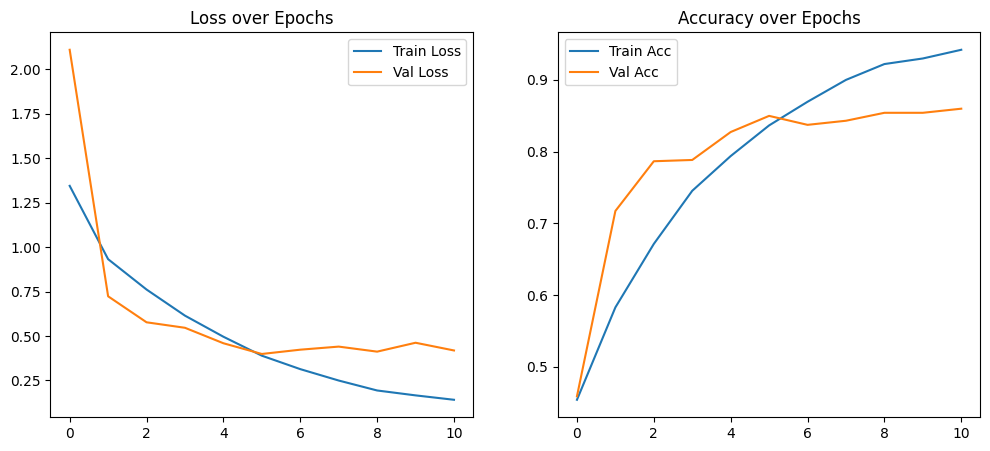

In [18]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()

In [19]:
from tensorflow.keras.models import load_model
model = load_model('best_cnn_model.h5')

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy = {test_acc:.4f}")
print(f"Test Loss = {test_loss:.4f}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - accuracy: 0.8404 - loss: 0.4095
Test Accuracy = 0.8404
Test Loss = 0.4095


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis=1)

print(classification_report(test_labels, pred_labels, target_names=classes))
cm = confusion_matrix(test_labels, pred_labels)
print(cm)

88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 165ms/step
              precision    recall  f1-score   support

         AMD       1.00      1.00      1.00       350
         CNV       0.75      0.85      0.80       350
         CSR       0.93      0.96      0.94       350
         DME       0.80      0.82      0.81       350
          DR       0.91      0.82      0.86       350
      DRUSEN       0.67      0.67      0.67       350
          MH       0.85      0.90      0.88       350
      NORMAL       0.83      0.70      0.76       350

    accuracy                           0.84      2800
   macro avg       0.84      0.84      0.84      2800
weighted avg       0.84      0.84      0.84      2800

[[350   0   0   0   0   0   0   0]
 [  0 298   0  17   0  34   0   1]
 [  0   0 336   0   6   0   8   0]
 [  0  23   0 287   0  22   0  18]
 [  0   0  17   0 287   0  46   0]
 [  0  69   0  16   0 233   0  32]
 [  0   0  10   0  24   0 316   0]
 [  0   7   0  37   0  60   0 246]]
